In [1]:
using QuantumLattices
using ExactDiagonalization
using QuantumClusterTheories
using Distributed
using Plots

In [2]:
unitcell = Lattice([0, 0]; vectors=[[1, 0], [0, 1]])
cluster = Lattice(unitcell, (2,2), ('p','p'))
hilbert = Hilbert(site=>Fock{:f}(1, 2) for site=1:length(cluster))
bs = BinaryBases([1:4,5:8], 0.0)
t = Hopping(:t, -1.0, 1)
U = Hubbard(:U, 8.0)
μ = Onsite(:μ, 1.2)
coupling1=Coupling(Index(:, FID(1, 1//2, 1)), Index(:, FID(1, -1//2, 1)))
coupling2=(Coupling(Index(:, FID(1, 1//2, 1)), Index(:, FID(1, -1//2, 1)))-Coupling(Index(:, FID(1, -1//2, 1)), Index(:, FID(1, 1//2, 1))))/2
origiterms = (t, U, μ)
neighbors = Neighbors(0=>0.0, 1=>1.0, 2=>√2)

Neighbors{Int64, Float64} with 3 entries:
  0 => 0.0
  2 => 1.41421
  1 => 1.0

In [3]:
s = Pairing(:s, 0.3, 0, coupling1)
referterms1 = (t, U, μ, s)

D = Pairing(:D, 0.3, 1, coupling2; amplitude=dx2y2)
referterms2 = (t, U, μ, D)

Es = Pairing(:Es, 0.3, 1, coupling2)
referterms3 = (t, U, μ, Es)

Dxy = Pairing(:Dxy, 0.3, 2, coupling2; amplitude=dxy)
referterms4 = (t, U, μ, Dxy)

(Term{:Hopping, :t, Float64, Int64, QuantumLattices.DegreesOfFreedom.TermCoupling{Coupling{Int64, Tuple{Index{Colon, FID{:*, Colon, Colon, Colon}}, Index{Colon, FID{:*, Colon, Colon, Colon}}}, Constraint{(2,), 1, Tuple{QuantumLattices.DegreesOfFreedom.Diagonal{(:orbital, :spin)}}}}, Coupling{Int64, Tuple{Index{Colon, FID{:*, Colon, Colon, Colon}}, Index{Colon, FID{:*, Colon, Colon, Colon}}}, Constraint{(2,), 1, Tuple{QuantumLattices.DegreesOfFreedom.Diagonal{(:orbital, :spin)}}}}}, QuantumLattices.DegreesOfFreedom.TermAmplitude{Nothing}, QuantumLattices.DegreesOfFreedom.TermModulate{Val{true}, :t}}(-1.0, 1, QuantumLattices.DegreesOfFreedom.TermCoupling{Coupling{Int64, Tuple{Index{Colon, FID{:*, Colon, Colon, Colon}}, Index{Colon, FID{:*, Colon, Colon, Colon}}}, Constraint{(2,), 1, Tuple{QuantumLattices.DegreesOfFreedom.Diagonal{(:orbital, :spin)}}}}, Coupling{Int64, Tuple{Index{Colon, FID{:*, Colon, Colon, Colon}}, Index{Colon, FID{:*, Colon, Colon, Colon}}}, Constraint{(2,), 1, Tuple{

 10.123930 seconds (50.65 M allocations: 2.572 GiB, 6.21% gc time, 99.52% compilation time)


  9.864518 seconds (93.25 M allocations: 13.316 GiB, 13.29% gc time, 19.32% compilation time)


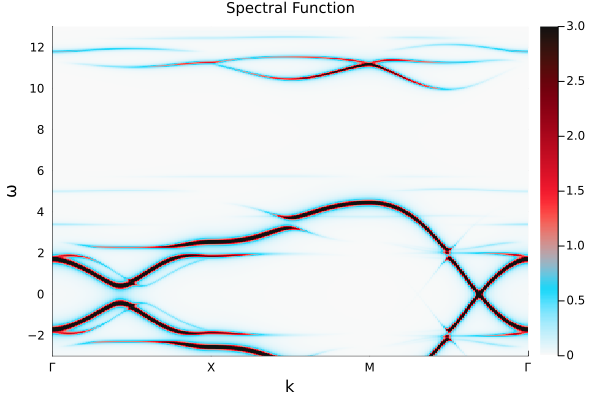

In [4]:
origiterms = (t, U, μ, D)
referterms = (t, U, μ, D)
@time vca = VCA(:A, unitcell, cluster, hilbert, origiterms, referterms, bs)
k_path = ReciprocalPath(reciprocals(unitcell.vectors), rectangle"Γ-X-M-Γ", length=100)
ω_range = range(-3, 13, length=500)
fq = ω_range .+ (0 + 0.05*im)
@time G = singleParticleGreenFunction(:f, vca, k_path, fq)
A = spectrum(G)
colorbar = cgrad(:linear_tritanopic_krjcw_5_98_c46_n256, rev = true)
f = plot(k_path, ω_range, A; xlabel="k", ylabel="ω", color=colorbar, title="Spectral Function",clims=(0, 3))


In [4]:
varparams1 = [(s = a,) for a in range(1e-9, 0.2, 20)]
varparams2 = [(D = a,) for a in range(1e-9, 0.2, 20)]
varparams3 = [(Es = a,) for a in range(1e-9, 0.2, 20)]
varparams4 = [(Dxy = a,) for a in range(1e-9, 0.2, 20)]
rz = ReciprocalZone(reciprocals(cluster.vectors); length=100)

spawn(8)
#=
@time vcas1 = pmap(param -> VCA(:A, unitcell, cluster, hilbert, origiterms, referterms1, bs, param; neighbors=neighbors, m=200), varparams1)
@time gps1 = pmap(vca -> GrandPotential(:f, vca, rz, 0.0), vcas1)
=#
@time vcas2 = pmap(param -> VCA(:A, unitcell, cluster, hilbert, origiterms, referterms2, bs, param; neighbors=neighbors, m=200), varparams2)
@time gps2 = pmap(vca -> GrandPotential(:f, vca, rz, 0.0), vcas2)
#=
@time vcas3 = pmap(param -> VCA(:A, unitcell, cluster, hilbert, origiterms, referterms3, bs, param; neighbors=neighbors, m=200), varparams3)
@time gps3 = pmap(vca -> GrandPotential(:f, vca, rz, 0.0), vcas3)
=#
#=
@time vcas4 = pmap(param -> VCA(:A, unitcell, cluster, hilbert, origiterms, referterms4, bs, param; neighbors=neighbors, m=200), varparams4)
@time gps4 = pmap(vca -> GrandPotential(:f, vca, rz, 0.0), vcas4)
=#

 24.353123 seconds (8.95 M allocations: 502.722 MiB, 0.52% gc time, 7.34% compilation time: 0% of which was recompilation)


 71.380162 seconds (3.79 M allocations: 203.351 MiB, 0.03% gc time, 0.90% compilation time)


20-element Vector{Float64}:
 -0.3184245626422714
 -0.31851430086649557
 -0.31878373805244725
 -0.3192338992053816
 -0.3198684410742138
 -0.3193024786044023
 -0.3180420245463979
 -0.316590175562896
 -0.3149642888446763
 -0.3131841604352438
 -0.3112704513682341
 -0.30923639474625353
 -0.3071016883730762
 -0.30489225458030544
 -0.3026202423980821
 -0.3003017329055888
 -0.2979665197886227
 -0.29561586026180464
 -0.2932813525373662
 -0.2909636773916471

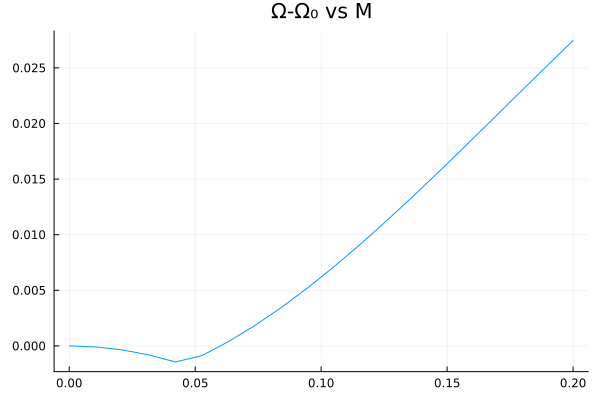

In [5]:
f2 = plot(range(0, 0.2, 20), gps2 .- gps2[1], label=nothing,legend=:topright, title="Ω-Ω₀ vs M")

  1.491846 seconds (1.35 M allocations: 91.987 MiB, 0.80% gc time, 11.91% compilation time)


 52.032091 seconds (325.64 k allocations: 23.981 MiB, 0.13% compilation time)


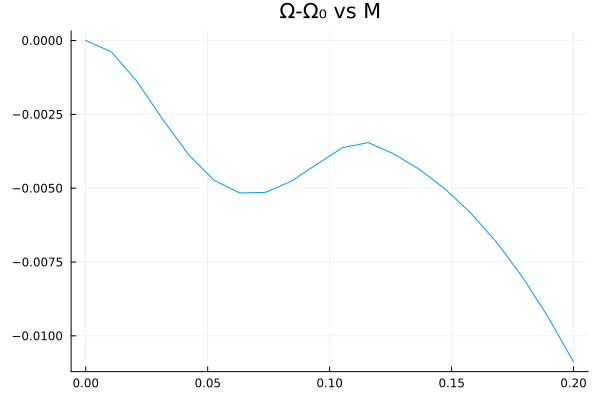

In [6]:
varparams3 = [(Es = a,) for a in range(1e-9, 0.2, 20)]
rz = ReciprocalZone(reciprocals(cluster.vectors); length=100)
spawn(8)
@time vcas3 = pmap(param -> VCA(:A, unitcell, cluster, hilbert, origiterms, referterms3, bs, param; neighbors=neighbors, m=200), varparams3)
@time gps3 = pmap(vca -> GrandPotential(:f, vca, rz, 0.0), vcas3)
f = plot(range(0, 0.2, 20), gps3 .- gps3[1], label=nothing,legend=:topright, title="Ω-Ω₀ vs M")